In [1]:
import spacy
import pandas as pd
import numpy as np

sp = spacy.load('en_core_web_sm')

#### Load datasets: 

In [ ]:
# original dataset, sampled
df = pd.read_csv('yelp.csv')
df = df.sample(500)

In [81]:
# tokenized dataset
df = pd.read_csv('yelp_processed_v3.csv')

# turn tokens back into arrays
import ast
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

if (type(df['text'][0] != 'text')): df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [82]:
df = pd.read_csv('yelp_processed_v4.csv')
df = df.sample(500)

In [83]:
df.head()


,Unnamed: 0,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,og_text
9910,9910,Bjt3rB73dvSDe1XEPEWc6w,2012-07-07,tdadRAEJVveG3j177Miw_A,5,great place sushi ordered musscles caution lar...,review,m5-3onu1zp4l50V-PmZKgg,0,1,0,"Great place for Sushi, ordered the Musscles ( ..."
406,406,bc-lE-wGVAsUrX-kJhtY-Q,2008-04-01,Tx0t7Jr6K7UicgbWympFsA,2,place bad many level im even sure begin server...,review,lPaYMDmJbAnv_3pmZH_inw,4,10,1,This place was so bad on so many levels I'm no...
289,289,l3yL2rQ6PoFBQ06RLczn9w,2010-08-21,Cluf-ijd2Ubr0hoVjLXoSQ,1,id say ive clubhouse time year past five year ...,review,80PHOfM8KOBb7xEQN4C0lg,0,0,0,I'd say I've been to the Clubhouse a few times...
8482,8482,rOHs19lhPWXiuPMHzNbJZg,2012-06-06,Tp5BCuA3xyONjY0VMho7YA,4,oh lawd im relative nevercomer cuisine like pe...,review,U5JyHRVayfHRHipogAq84A,0,1,0,"Oh lawd!!!\n\nSo, I'm a relative nevercomer to..."
2012,2012,1DjRf3AdYpdlC1Df9KD6rA,2010-02-16,cMiI02mYDrr7fWJyTEz1YA,3,went due restaurantcom coupon menu expensive m...,review,U3uT-Phb8iL2iuZpAROZlg,0,0,0,I went here due to a Restaurant.com coupon. Th...


## Preprocessing

#### Aspect Extraction

In [112]:
# aspect extraction with spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# mostly unprocessed, but with stopwords removed. Without this, most categories are [it its it's], [you yours yourself], etc
stop_words = set(stopwords.words('english'))
stop_words.update(['you', 'they', 'this', 'we', 'us', 'try', 'the'])

def extract_aspects(text): 
    text = text.lower()
    doc = sp(text)
    return [chunk.text for chunk in doc.noun_chunks if str(chunk) not in stop_words]

# extract aspects from original text 
df['aspects'] = df['og_text'].apply(extract_aspects)

print(df[['aspects', 'og_text']])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarahikogan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                aspects  \
9910  [great place, sushi, the musscles, very large ...   
406   [this place, so many levels, our server, honey...   
289   [the clubhouse, the past five years, the venue...   
8482  [a relative nevercomer, this cuisine, most peo...   
2012  [a restaurant.com coupon, the menu, a fancy pl...   
...                                                 ...   
3828  [their ritas, the rocks, their shrimp tacos, t...   
49    [my last review, the burgers, an invite, the m...   
7975  [this place, a reason, these sandwiches, so ma...   
5638  [all these negative reviews, the prices, a goo...   
2891  [a town, arguably dozens, grocery options, bai...   

                                                og_text  
9910  Great place for Sushi, ordered the Musscles ( ...  
406   This place was so bad on so many levels I'm no...  
289   I'd say I've been to the Clubhouse a few times...  
8482  Oh lawd!!!\n\nSo, I'm a relative nevercomer to...  
2

In [108]:
# aspect clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

aspects = [i for s in df['aspects'] for i in s] # flatten list for processing

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aspects)

# clusters 
kmeans = KMeans(n_clusters = 20, random_state=0)
clusters = kmeans.fit_predict(X)

# assign clusters
aspect_clusters = {aspect: f"Category: {clusters[i]}" for i, aspect in enumerate(aspects)}
print(aspect_clusters)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'great place': 'Category: 18', 'sushi': 'Category: 6', 'the musscles': 'Category: 7', 'very large order': 'Category: 6', 'only four) great wine': 'Category: 8', 'eel crunch roll': 'Category: 6', 'tuna roll': 'Category: 6', 'soft shell crab roll': 'Category: 6', 'a little gem': 'Category: 6', 'pricing': 'Category: 6', 'environment': 'Category: 6', 'service': 'Category: 17', 'suggestions': 'Category: 6', 'information': 'Category: 6', 'this place': 'Category: 18', 'so many levels': 'Category: 6', 'our server': 'Category: 6', 'honey': 'Category: 6', 'such a hurry': 'Category: 6', 'the baked spinach': 'Category: 7', 'dip': 'Category: 6', 'the chef': 'Category: 7', 'no one': 'Category: 16', 'the scorched burnt smoke': 'Category: 7', 'the dish': 'Category: 15', 'this thing': 'Category: 8', 'another one': 'Category: 16', 'the food': 'Category: 2', 'their famous bbq ribs': 'Category: 4', 'old ribs': 'Category: 6', 'pork': 'Category: 6', 'a funky taste': 'Category: 6', 'the texture': 'Category:

In [ ]:
# list words in each cluster
from collections import defaultdict

cluster_words = defaultdict(list)
cluster_counts = defaultdict(int)

for aspect, cluster in aspect_clusters.items(): 
    cluster_words[cluster].append(aspect)

# count how many times each cluster appears in the text, to find which ones are most relevant
for text in df['text']:
    words = text.lower().split()
    for cluster, aspects in cluster_words.items(): 
        for aspect in aspects: 
            if aspect in words: 
                cluster_counts[cluster] += 1

for cluster, words in cluster_words.items():
    print(f"Cluster {cluster}: {words} \nOccurences: {cluster_counts[cluster]}")

coherence_model_lda = CoherenceModel(model=)
print("Cluster coherence: ")

Cluster Category: 18: ['great place', 'this place', 'a place', 'this little place', 'the place', 'place', 'a great place', 'the last place', 'your place', 'this-', 'price place', 'the first place', 'a unique place', 'this good-sized place', 'the perfect place', 'this place rocks', 'a little place', 'that place', 'a small place', 'her place', 'my place', 'excellent place', 'a beautiful place', 'every place', 'the right place', 'another place', 'no place', 'nice place', 'little place', 'good place', "this.i'm", 'not a place', 'such a place'] 
Occurences: 201
Cluster Category: 6: ['sushi', 'very large order', 'eel crunch roll', 'tuna roll', 'soft shell crab roll', 'a little gem', 'pricing', 'environment', 'suggestions', 'information', 'so many levels', 'our server', 'honey', 'such a hurry', 'dip', 'old ribs', 'pork', 'a funky taste', 'jerky', 'more then 2 bones', 'dessert', 'charlie', 'many redeeming qualities', 'a shame', 'a bad night', 'all means', 'some very common themes', 'different 

### Aspect extraction with processed text - nouns

In [113]:
# aspect extraction with spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# mostly unprocessed, but with stopwords removed. Without this, most categories are [it its it's], [you yours yourself], etc
stop_words = set(stopwords.words('english'))
stop_words.update(['you', 'they', 'this', 'we', 'us', 'try', 'the'])

def extract_aspects(text): 
    doc = sp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

# extract aspects from original text 
df['aspects'] = df['text'].apply(extract_aspects)

print(df[['aspects', 'text']])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarahikogan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                aspects  \
9910  [place, musscles, order, wine, tuna, roll, she...   
406   [level, server, honey, hurry, need, spinach, d...   
289   [time, year, year, person, theme, show, artist...   
8482  [nevercomer, cuisine, people, panda, food, meh...   
2012  [restaurantcom, coupon, menu, place, food, res...   
...                                                 ...   
3828  [rock, shrimp, town, love, staff, price, food,...   
49    [review, burger, invite, management, chef, try...   
7975  [place, reason, sandwich, people, place, place...   
5638  [review, d, start, price, love, deal, price, h...   
2891  [town, dozen, grocery, option, gem, desert, dr...   

                                                   text  
9910  great place sushi ordered musscles caution lar...  
406   place bad many level im even sure begin server...  
289   id say ive clubhouse time year past five year ...  
8482  oh lawd im relative nevercomer cuisine like pe...  
2

In [118]:
# aspect clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

aspects = [i for s in df['aspects'] for i in s] # flatten list for processing

vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.85)
X = vectorizer.fit_transform(aspects)

# clusters 
kmeans = KMeans(n_clusters = 5, random_state=0)
clusters = kmeans.fit_predict(X)

# assign clusters
aspect_clusters = {aspect: f"Category: {clusters[i]}" for i, aspect in enumerate(aspects)}
print(aspect_clusters)

{'place': 'Category: 2', 'musscles': 'Category: 0', 'order': 'Category: 0', 'wine': 'Category: 0', 'tuna': 'Category: 0', 'roll': 'Category: 0', 'shell': 'Category: 0', 'crab': 'Category: 0', 'gem': 'Category: 0', 'pricing': 'Category: 0', 'environment': 'Category: 0', 'service': 'Category: 0', 'suggestion': 'Category: 0', 'information': 'Category: 0', 'level': 'Category: 0', 'server': 'Category: 0', 'honey': 'Category: 0', 'hurry': 'Category: 0', 'need': 'Category: 0', 'spinach': 'Category: 0', 'dip': 'Category: 0', 'chef': 'Category: 0', 'smoke': 'Category: 0', 'dish': 'Category: 0', 'thing': 'Category: 0', 'one': 'Category: 0', 'food': 'Category: 1', 'bbq': 'Category: 0', 'rib': 'Category: 0', 'day': 'Category: 0', 'pork': 'Category: 0', 'taste': 'Category: 0', 'texture': 'Category: 0', 'meat': 'Category: 0', 'star': 'Category: 0', 'bone': 'Category: 0', 'waitress': 'Category: 0', 'plate': 'Category: 0', 'u': 'Category: 0', 'dessert': 'Category: 0', 'charlies': 'Category: 0', 'quali

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [119]:
# list words in each cluster
from collections import defaultdict

cluster_words = defaultdict(list)
cluster_counts = defaultdict(int)

for aspect, cluster in aspect_clusters.items(): 
    cluster_words[cluster].append(aspect)

# count how many times each cluster appears in the text, to find which ones are most relevant
for text in df['text']:
    words = text.lower().split()
    for cluster, aspects in cluster_words.items(): 
        for aspect in aspects: 
            if aspect in words: 
                cluster_counts[cluster] += 1

for cluster, words in cluster_words.items():
    print(f"Cluster {cluster}: {words} \nOccurences: {cluster_counts[cluster]}")

Cluster Category: 2: ['place'] 
Occurences: 250
Cluster Category: 0: ['musscles', 'order', 'wine', 'tuna', 'roll', 'shell', 'crab', 'gem', 'pricing', 'environment', 'service', 'suggestion', 'information', 'level', 'server', 'honey', 'hurry', 'need', 'spinach', 'dip', 'chef', 'smoke', 'dish', 'thing', 'one', 'bbq', 'rib', 'day', 'pork', 'taste', 'texture', 'meat', 'star', 'bone', 'waitress', 'plate', 'u', 'dessert', 'charlies', 'quality', 'shame', 'yelp', 'night', 'find', 'year', 'person', 'theme', 'show', 'artist', 'genre', 'crowd', 'sound', 'band', 'venue', 'monitor', 'turn', 'play', 'observation', 'return', 'music', 'isntlets', 'metal', 'hardcore', 'thrasher', 'others', 'location', 'opinion', 'skewed', 'pant', 'tip', 'exit', 'issue', 'answer', 'question', 'bar', 'patron', 'money', 'bartender', 'customer', 'beverage', 'purchase', 'concept', 'hate', 'business', 'feedback', 'format', 'chance', 'forgo', 'pantaloon', 'support', 'way', 'flask', 'sans', 'bottom', 'nevercomer', 'cuisine', 'p

### LDA 

In [ ]:
#LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

aspects = [i for s in df['aspects'] for i in s] # flatten list for processing

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

# fit model 
lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(X)

LatentDirichletAllocation(random_state=0)

In [132]:
words = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_): 
    print(f"Topic {topic_idx}:")
    print(" ".join([words[i] for i in topic.argsort()[:-20 - 1:-1]]))

Topic 0:
tire south winner mexicanchinesejamaican typically read chandler ride glad tasteless pho aa please yuck delay airline accommodating martini thomas filthy
Topic 1:
slow strange body reservation chocolate shopping outstanding pho dork strike werent hate hot wanted kimchi value edison bulb rejuvanation early
Topic 2:
seating barbecue smell become turd aura dive taken looked heard troy snotty death aware visi facility ihop chunky ken gras
Topic 3:
place good food great like time one service get go love really always dont little im restaurant back would best
Topic 4:
waffle boba chance cake hot butter sebastian thai soda iced voice list cherry hold fellow tour winter grit yelpers capriottis
Topic 5:
crepe garlic barber guacamole yuk hot pricy vet gain ca wanting brace sucked salmon somewhere relleno serve purchase ridiculous quote
Topic 6:
hotel wrap card gross froo brow meatball sucked solid lady jazz vegan olive kitchen mmmmmmm tzatziki ate shes contemporary boutique
Topic 7:
cou

### lda 2

In [150]:
import gensim
from gensim import corpora

df = pd.read_csv('yelp_processed_v4.csv')
df = df.sample(1000)
df['tokens'] = [w.split() for w in df['text']]
print(df['tokens'])
# dictionary
dictionary = corpora.Dictionary(df['tokens'])
doc_term_matrix = [dictionary.doc2bow(rev) for rev in df['tokens']]

LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, 
                num_topics=6, random_state=100, 
                chunksize=1000, passes=50, iterations=100)
lda_model.print_topics()

4560    [nonred, meat, eater, walked, kegthats, story,...
3868    [absolutely, love, food, service, good, food, ...
1414    [ok, wisconsin, land, great, lake, completely,...
1896    [going, year, staff, always, pleasant, place, ...
6774    [love, location, repurposed, historical, house...
                              ...                        
2160    [ive, going, orange, theory, awhile, cant, bel...
4611    [must, visit, heard, staff, professional, jame...
9551    [love, store, produce, always, fresh, interest...
5936    [imagine, scene, saturday, morning, house, col...
9738    [always, connect, fly, u, airway, la, vega, ev...
Name: tokens, Length: 1000, dtype: object


[(0,
  '0.011*"time" + 0.009*"great" + 0.009*"good" + 0.007*"food" + 0.006*"place" + 0.006*"ive" + 0.006*"always" + 0.006*"like" + 0.006*"nice" + 0.005*"service"'),
 (1,
  '0.004*"shoe" + 0.003*"new" + 0.003*"year" + 0.002*"day" + 0.002*"staff" + 0.002*"ariel" + 0.002*"pair" + 0.002*"lettuce" + 0.002*"great" + 0.002*"since"'),
 (2,
  '0.015*"food" + 0.012*"good" + 0.012*"place" + 0.009*"like" + 0.008*"great" + 0.007*"one" + 0.007*"really" + 0.006*"time" + 0.005*"restaurant" + 0.005*"go"'),
 (3,
  '0.007*"one" + 0.006*"time" + 0.005*"would" + 0.004*"place" + 0.004*"store" + 0.004*"get" + 0.004*"location" + 0.004*"u" + 0.003*"table" + 0.003*"day"'),
 (4,
  '0.012*"place" + 0.008*"one" + 0.008*"time" + 0.007*"like" + 0.007*"get" + 0.007*"go" + 0.007*"good" + 0.006*"food" + 0.006*"great" + 0.006*"bar"'),
 (5,
  '0.010*"good" + 0.008*"like" + 0.008*"sandwich" + 0.006*"place" + 0.006*"food" + 0.005*"get" + 0.005*"pizza" + 0.005*"salad" + 0.005*"would" + 0.005*"great"')]

In [ ]:
# lda statistics
from gensim.models import CoherenceModel, LdaModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence: ', coherence_lda)

Coherence:  0.3205414379182459


5
Coherence:  0.318916705341184
6
Coherence:  0.3218694804050937
7
Coherence:  0.31643392792553066
8
Coherence:  0.30115585933218936
9
Coherence:  0.30314798708388957
10
Coherence:  0.3122722864190471
11
Coherence:  0.31030864184603696
12
Coherence:  0.30608656530394557
13
Coherence:  0.3032407689246253
14
Coherence:  0.30532191727335534
15
Coherence:  0.3061299161162284
16
Coherence:  0.29175554552003247
17
Coherence:  0.2897844942595909
18
Coherence:  0.2883719224411288
19
Coherence:  0.29261234900086963


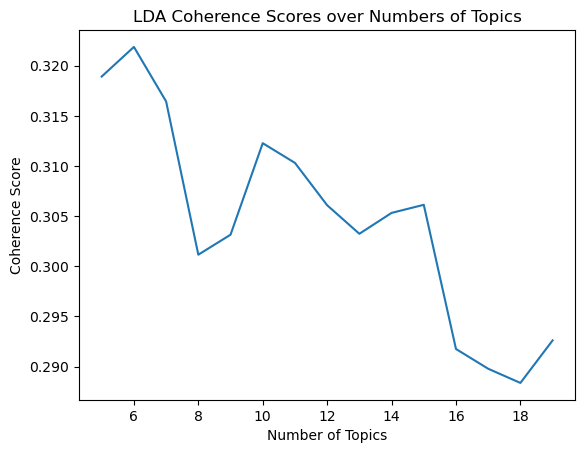

In [149]:
# try different scores
import matplotlib.pyplot as plt

topic_range = range(5, 20)
coherence_scores = []

for i in range(5, 20): 
    print(i)
    LDA = gensim.models.ldamodel.LdaModel
    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, 
                    num_topics=i, random_state=0, 
                    chunksize=1000, passes=25, iterations=100)
    lda_model.print_topics()

    coherence_model_lda = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence: ', coherence_lda)
    coherence_scores.append(coherence_lda)

plt.plot(topic_range, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('LDA Coherence Scores over Numbers of Topics')
plt.show()

### ABSA


Assign aspects for each document

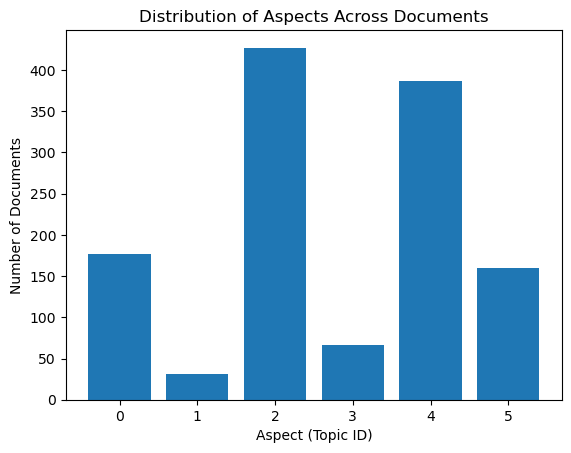

In [161]:
def get_aspects(text, threshold=0.2):
    bow = dictionary.doc2bow(text)
    topic_distribution = lda_model.get_document_topics(bow)

    #for topic_id, topic_words in lda_model.print_topics(num_topics=5, num_words=5):
    #    print(f"Topic {topic_id}: {topic_words}")

    return [topic for topic, prob in topic_distribution if prob >= threshold]

df['lda_aspects'] = df['tokens'].apply(get_aspects)

import matplotlib.pyplot as plt
from collections import Counter

# Count the number of documents with each aspect
aspect_counts = Counter([aspect for aspects_list in df['lda_aspects'] for aspect in aspects_list])

# Plot aspect distribution
plt.bar(aspect_counts.keys(), aspect_counts.values())
plt.xlabel('Aspect (Topic ID)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Aspects Across Documents')
plt.show()